In [6]:
import pandas as pd

In [7]:
from datasets import load_from_disk

# Load the Yelp review data from the disk
yelp_data = load_from_disk('/home/snow/NEU/CS6120/Assignments/A4/dataset/train')

# Convert to a pandas dataframe and print the first 5 examples
import pandas as pd
yelp_df = pd.DataFrame(yelp_data)




In [8]:
yelp_df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [9]:
yelp_df.size

1300000

In [10]:
yelp_df.tail

<bound method NDFrame.tail of         label                                               text
0           4  dr. goldberg offers everything i look for in a...
1           1  Unfortunately, the frustration of being Dr. Go...
2           3  Been going to Dr. Goldberg for over 10 years. ...
3           3  Got a letter in the mail last week that said D...
4           0  I don't know what Dr. Goldberg was like before...
...       ...                                                ...
649995      4  I had a sprinkler that was gushing... pipe bro...
649996      0  Phone calls always go to voicemail and message...
649997      0  Looks like all of the good reviews have gone t...
649998      4  I was able to once again rely on Yelp to provi...
649999      0  I have been using this company for 11 months. ...

[650000 rows x 2 columns]>

In [11]:
yelp_df.columns

Index(['label', 'text'], dtype='object')

Next, we will investigate how many tokens each review has?

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def count_tokens(text, tokenizer=tokenizer):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

yelp_df['token_counts'] = yelp_df['text'].apply(count_tokens)

Now let's see how long our text is?

In [13]:
yelp_df.token_counts.describe()

count    650000.000000
mean        178.696091
std         163.847267
min           1.000000
25%          69.000000
50%         130.000000
75%         234.000000
max        2342.000000
Name: token_counts, dtype: float64

Interesting.

Let's break this down. We can see that the average token count sits at 178, which is comfortably less than half the context window.

However, mean is not a good statistic in this case.

We can see that the minimum length and the maximum length are both very extreme (compared to the context length of most BeRT models). The first one is just one token long.

The 50% deviation mark actually lies towards 130 tokens than 178. 

Let's see how many tokens are above the context length of a typical BeRT model.

In [14]:
print(len(yelp_df[yelp_df['token_counts'] > 512]))

29932


That is a lot of reviews above 512 tokens! This is why we need to make sure that we can capture the entire context potentially. If possible, we need to devise a strategy during implementation to capture parts of a review that might be truncated otherwise.


Next, let's properly visualize what the distribution of reviews across the board is.

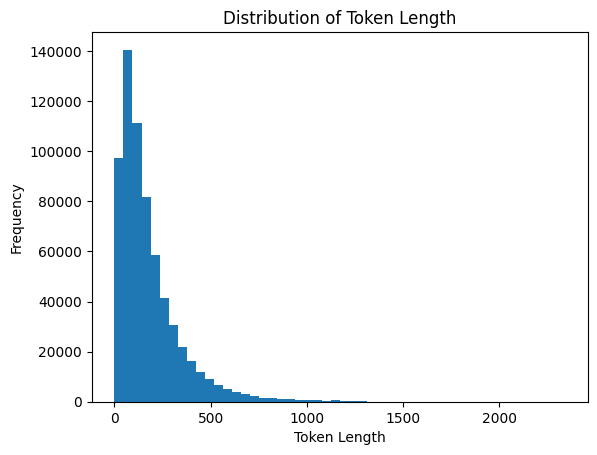

In [15]:
import matplotlib.pyplot as plt

def token_distribution(token_counts):
    plt.hist(token_counts, bins=50)
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Length')
    plt.show()

token_distribution(yelp_df['token_counts'])

Let's look at token counts below 512 more closely

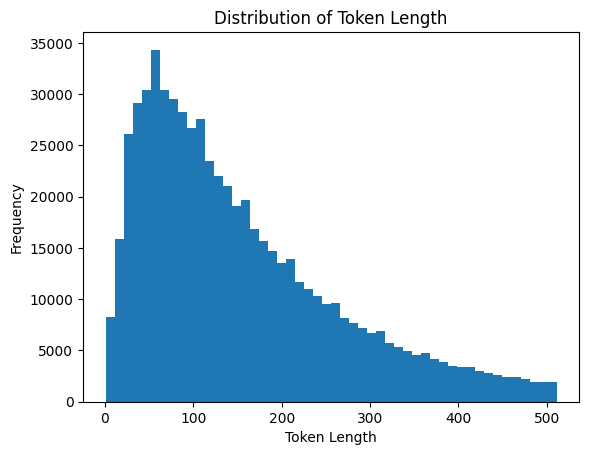

513.0

In [16]:
token_distribution(yelp_df[yelp_df['token_counts'] < 512]['token_counts'])

yelp_df['token_counts'].quantile(0.954)

Approximately 95.4% of the dataset is under 512 tokens.

Now let's look at other tokens above 512.

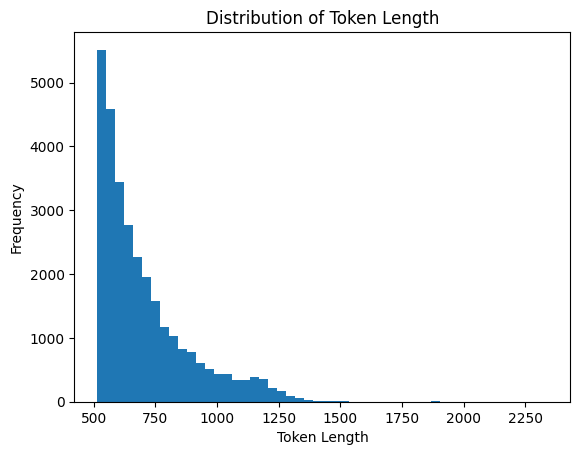

513.0

In [17]:
token_distribution(yelp_df[yelp_df['token_counts'] > 512]['token_counts'])

yelp_df['token_counts'].quantile(0.954)

It would be interesting to see how the accuracy of the model we use is impacted by the context length and the length of the sentence itself

Let's look for any class imbalance potentially..

In [18]:
yelp_df.label.value_counts()

label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64

No class imbalance found! That's pretty good. ALthough that should not matter as much since we are not training a model.

Let's see what kind of words are used by each kind of review.

First, we will categorize a rating of 3 and 4 as Positive

A rating of 2 is neutral, and a rating of 0-1 is negative

Let us add the labels to the reviews according to this.

In [19]:
def assign_sentiment_label(row):
    if row['label'] in [3, 4]:
        return 'positive'
    elif row['label'] == 2:
        return 'neutral'
    else:
        return 'negative'

yelp_df['sentiment'] = yelp_df.apply(assign_sentiment_label, axis=1)


In [20]:
yelp_df.sentiment.value_counts()

sentiment
positive    260000
negative    260000
neutral     130000
Name: count, dtype: int64

Now let's see what kind of words each class is utilizing

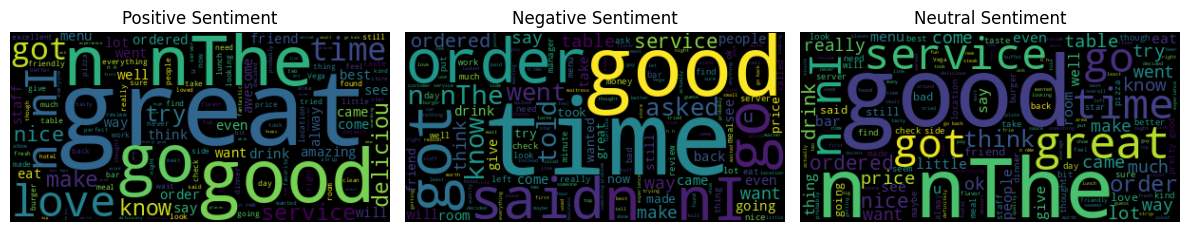

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Filter the dataframe based on sentiment
positive_df = yelp_df[yelp_df['sentiment'] == 'positive']
negative_df = yelp_df[yelp_df['sentiment'] == 'negative']
neutral_df = yelp_df[yelp_df['sentiment'] == 'neutral']

# Generate word clouds for each sentiment
positive_text = ' '.join(positive_df['text'])
negative_text = ' '.join(negative_df['text'])
neutral_text = ' '.join(neutral_df['text'])

STOPWORDS.add('food')
STOPWORDS.add('place')
STOPWORDS.add('restaurant')
STOPWORDS.add('one')

# Create word cloud objects
positive_wordcloud = WordCloud(stopwords=STOPWORDS).generate(positive_text)
negative_wordcloud = WordCloud(stopwords=STOPWORDS).generate(negative_text)
neutral_wordcloud = WordCloud(stopwords=STOPWORDS).generate(neutral_text)

# Plot the word clouds
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()



A wordcloud is good for analysing the frequency of text, but it does not give us any clue on the relevance.

For that, we must do keyword extraction.

In [29]:
from rake_nltk import Rake


# Initialize the RAKE extractor
r = Rake()

# Extract keywords for each review
positive_df['keywords'] = positive_df['text'].apply(lambda x: r.extract_keywords_from_text(x))
positive_df['ranked_keywords'] = positive_df['keywords'].apply(lambda x: r.get_ranked_phrases())
negative_df['keywords'] = negative_df['text'].apply(lambda x: r.extract_keywords_from_text(x))
negative_df['ranked_keywords'] = negative_df['keywords'].apply(lambda x: r.get_ranked_phrases())
neutral_df['keywords'] = neutral_df['text'].apply(lambda x: r.extract_keywords_from_text(x))
neutral_df['ranked_keywords'] = neutral_df['keywords'].apply(lambda x: r.get_ranked_phrases())

/tmp/ipykernel_6102/3309770875.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['keywords'] = positive_df['text'].apply(lambda x: r.extract_keywords_from_text(x))
/tmp/ipykernel_6102/3309770875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['ranked_keywords'] = positive_df['keywords'].apply(lambda x: r.get_ranked_phrases())
/tmp/ipykernel_6102/3309770875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

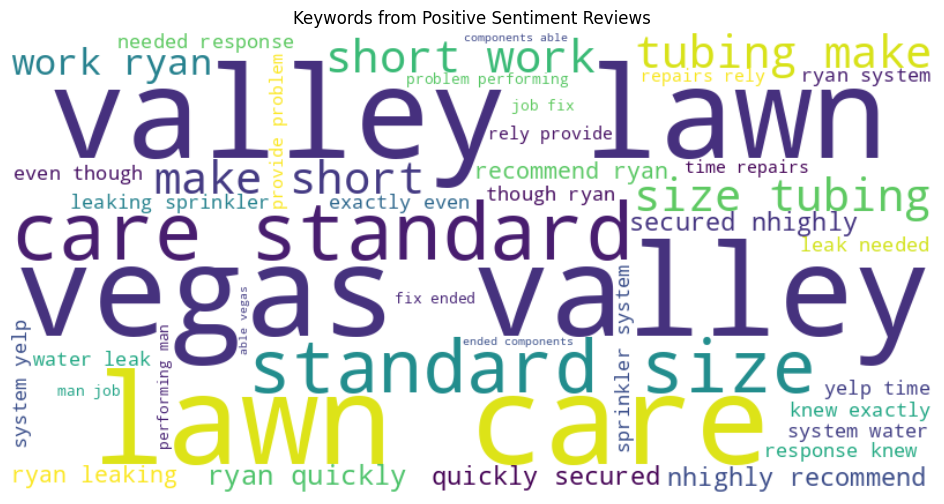

In [30]:
# Concatenate all the ranked keywords for positive sentiment
positive_keywords = ' '.join([' '.join(keywords) for keywords in positive_df['ranked_keywords']])

# Generate the word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_keywords)

# Plot the word cloud for positive sentiment
plt.figure(figsize=(12, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords from Positive Sentiment Reviews')
plt.show()

In [31]:
neutral_df['ranked_keywords']

9         [added something like bread crumbs, nice big a...
21        [added something like bread crumbs, nice big a...
33        [added something like bread crumbs, nice big a...
37        [added something like bread crumbs, nice big a...
45        [added something like bread crumbs, nice big a...
                                ...                        
649968    [added something like bread crumbs, nice big a...
649971    [added something like bread crumbs, nice big a...
649973    [added something like bread crumbs, nice big a...
649977    [added something like bread crumbs, nice big a...
649978    [added something like bread crumbs, nice big a...
Name: ranked_keywords, Length: 130000, dtype: object

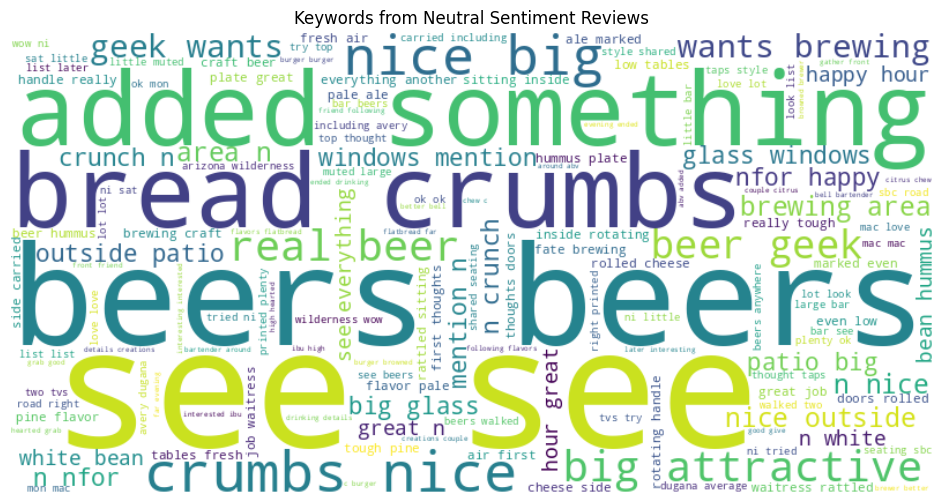

In [34]:
# Concatenate all the ranked keywords for positive sentiment
neutral_keywords = ' '.join([' '.join(keywords) for keywords in neutral_df['ranked_keywords']])

# Generate the word cloud for positive sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_keywords)

# Plot the word cloud for positive sentiment
plt.figure(figsize=(12, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords from Neutral Sentiment Reviews')
plt.show()

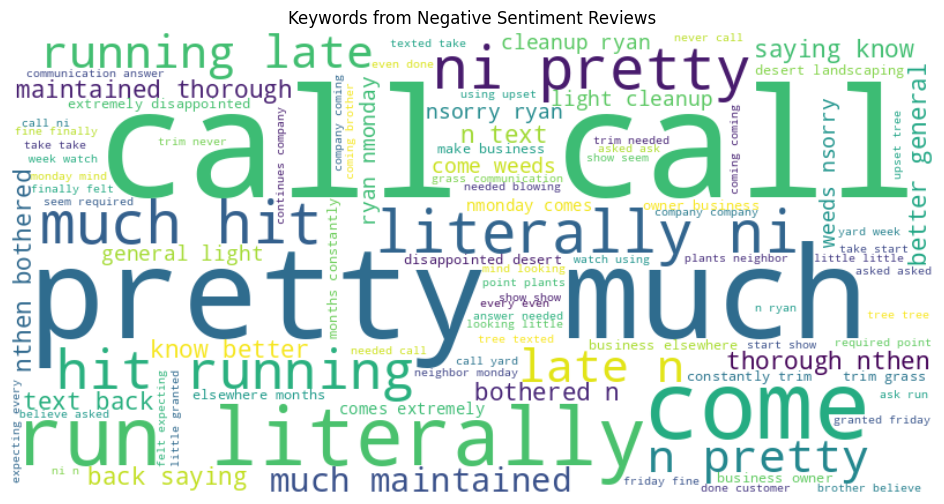

In [35]:
# Concatenate all the ranked keywords for positive sentiment
negative_keywords = ' '.join([' '.join(keywords) for keywords in negative_df['ranked_keywords']])

# Generate the word cloud for positive sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_keywords)

# Plot the word cloud for positive sentiment
plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords from Negative Sentiment Reviews')
plt.show()

Now we can see that there's different words in different sentiments


Positive Sentiment has words like recommend and quickly
Negative Sentiment has words like running late, and never call, and bothered
Neutral is a mix of all these words and other similar words


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [55]:
yelp_df

,label,text,token_counts,sentiment
0,4,dr. goldberg offers everything i look for in a...,120,positive
1,1,"Unfortunately, the frustration of being Dr. Go...",148,negative
2,3,Been going to Dr. Goldberg for over 10 years. ...,118,positive
3,3,Got a letter in the mail last week that said D...,60,positive
4,0,I don't know what Dr. Goldberg was like before...,249,negative
...,...,...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...,84,positive
649996,0,Phone calls always go to voicemail and message...,19,negative
649997,0,Looks like all of the good reviews have gone t...,100,negative
649998,4,I was able to once again rely on Yelp to provi...,87,positive
